In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sklearn
import numpy as np
import pandas as pd
data = pd.read_csv('NFL-PBPDataCleanedUpdate.csv')
pd.set_option('display.max_columns', None)
data = data.drop(columns=['Unnamed: 0', 'game_id', 'desc', 'qb_scramble', 'qb_dropback','air_yards', 'roof', 'run_gap'])

import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F


import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, Input, ZeroPadding1D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,play_type,shotgun,no_huddle,pass_length,pass_location,run_location,posteam_type,half_seconds_remaining,yards_gained,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,1,10,77,0,3590,run,0,0,NaN,NaN,left,home,1790,-3,3,3,0,0,0.546969,0.460187,-1.0,40.5,grass,76.0,7.0,0.441336
1,2,13,80,0,3557,pass,0,0,short,right,NaN,home,1757,7,3,3,0,0,0.520599,0.400522,-1.0,40.5,grass,76.0,7.0,0.606305
2,3,6,73,0,3517,pass,0,0,deep,left,NaN,home,1717,23,3,3,0,0,0.512282,0.417211,-1.0,40.5,grass,76.0,7.0,0.972548
3,1,10,50,0,3491,run,0,0,NaN,NaN,left,home,1691,0,3,3,0,0,0.584447,0.490365,-1.0,40.5,grass,76.0,7.0,0.443912
4,2,10,50,0,3453,pass,0,0,deep,right,NaN,home,1653,0,3,3,0,0,0.566532,0.460875,-1.0,40.5,grass,76.0,7.0,0.485260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,3,4,86,-6,44,pass,1,0,short,left,NaN,home,44,0,0,1,14,20,0.065262,0.037043,-6.5,43.5,grass,38.0,10.0,0.986473
322461,4,4,86,-6,38,run,1,0,NaN,NaN,middle,home,38,12,0,1,14,20,0.046147,0.022904,-6.5,43.5,grass,38.0,10.0,0.993961
322462,1,10,74,-6,16,pass,1,1,deep,right,NaN,home,16,0,0,1,14,20,0.044689,0.023246,-6.5,43.5,grass,38.0,10.0,0.990118
322463,2,10,74,-6,11,pass,1,0,short,left,NaN,home,11,0,0,1,14,20,0.033163,0.016259,-6.5,43.5,grass,38.0,10.0,0.992962


In [5]:
data = data.drop(columns=['pass_length', 'pass_location', 'run_location'])

In [6]:
data = data.drop(columns=['yards_gained'])
data = data.dropna()
y = data.pop('play_type')
data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,1,10,77,0,3590,0,0,home,1790,3,3,0,0,0.546969,0.460187,-1.0,40.5,grass,76.0,7.0,0.441336
1,2,13,80,0,3557,0,0,home,1757,3,3,0,0,0.520599,0.400522,-1.0,40.5,grass,76.0,7.0,0.606305
2,3,6,73,0,3517,0,0,home,1717,3,3,0,0,0.512282,0.417211,-1.0,40.5,grass,76.0,7.0,0.972548
3,1,10,50,0,3491,0,0,home,1691,3,3,0,0,0.584447,0.490365,-1.0,40.5,grass,76.0,7.0,0.443912
4,2,10,50,0,3453,0,0,home,1653,3,3,0,0,0.566532,0.460875,-1.0,40.5,grass,76.0,7.0,0.485260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,3,4,86,-6,44,1,0,home,44,0,1,14,20,0.065262,0.037043,-6.5,43.5,grass,38.0,10.0,0.986473
322461,4,4,86,-6,38,1,0,home,38,0,1,14,20,0.046147,0.022904,-6.5,43.5,grass,38.0,10.0,0.993961
322462,1,10,74,-6,16,1,1,home,16,0,1,14,20,0.044689,0.023246,-6.5,43.5,grass,38.0,10.0,0.990118
322463,2,10,74,-6,11,1,0,home,11,0,1,14,20,0.033163,0.016259,-6.5,43.5,grass,38.0,10.0,0.992962


In [7]:
def play_to_bin(col):
    newcol = []
    for val in col:
        if val == 'run':
             newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [8]:
y = play_to_bin(y)
y = np.array(y)

In [9]:
def posteam_type_to_bin(col):
    newcol = []
    for val in col:
        if val == 'home':
             newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [10]:
def surface_to_bin(col):
    newcol = []
    for val in col:
        if val == 'grass':
            newcol.append(0);
        else:
            newcol.append(1);
    
    return newcol

In [11]:
data['posteam_type'] = posteam_type_to_bin(data['posteam_type'])
data['surface'] = surface_to_bin(data['surface'])
data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,1,10,77,0,3590,0,0,0,1790,3,3,0,0,0.546969,0.460187,-1.0,40.5,0,76.0,7.0,0.441336
1,2,13,80,0,3557,0,0,0,1757,3,3,0,0,0.520599,0.400522,-1.0,40.5,0,76.0,7.0,0.606305
2,3,6,73,0,3517,0,0,0,1717,3,3,0,0,0.512282,0.417211,-1.0,40.5,0,76.0,7.0,0.972548
3,1,10,50,0,3491,0,0,0,1691,3,3,0,0,0.584447,0.490365,-1.0,40.5,0,76.0,7.0,0.443912
4,2,10,50,0,3453,0,0,0,1653,3,3,0,0,0.566532,0.460875,-1.0,40.5,0,76.0,7.0,0.485260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,3,4,86,-6,44,1,0,0,44,0,1,14,20,0.065262,0.037043,-6.5,43.5,0,38.0,10.0,0.986473
322461,4,4,86,-6,38,1,0,0,38,0,1,14,20,0.046147,0.022904,-6.5,43.5,0,38.0,10.0,0.993961
322462,1,10,74,-6,16,1,1,0,16,0,1,14,20,0.044689,0.023246,-6.5,43.5,0,38.0,10.0,0.990118
322463,2,10,74,-6,11,1,0,0,11,0,1,14,20,0.033163,0.016259,-6.5,43.5,0,38.0,10.0,0.992962


In [12]:
for col in data:
    data[col] = (data[col] - pd.DataFrame.mean(data[col]))/(pd.DataFrame.max(data[col]) - pd.DataFrame.min(data[col]))

In [13]:
data

,down,ydstogo,yardline_100,score_differential,game_seconds_remaining,shotgun,no_huddle,posteam_type,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,wp,vegas_wp,spread_line,total_line,surface,temp,wind,xpass
0,-0.265105,0.027795,0.251373,0.013437,0.512641,-0.596104,-0.10532,-0.501188,0.521722,0.143124,0.133870,-0.170878,-0.196612,0.045348,-0.041665,-0.066188,-0.146641,-0.280071,0.174517,-0.016768,-0.173510
1,0.068228,0.089019,0.281985,0.013437,0.503474,-0.596104,-0.10532,-0.501188,0.503388,0.143124,0.133870,-0.170878,-0.196612,0.018976,-0.101331,-0.066188,-0.146641,-0.280071,0.174517,-0.016768,-0.006450
2,0.401561,-0.053838,0.210556,0.013437,0.492363,-0.596104,-0.10532,-0.501188,0.481166,0.143124,0.133870,-0.170878,-0.196612,0.010658,-0.084642,-0.066188,-0.146641,-0.280071,0.174517,-0.016768,0.364438
3,-0.265105,0.027795,-0.024137,0.013437,0.485141,-0.596104,-0.10532,-0.501188,0.466722,0.143124,0.133870,-0.170878,-0.196612,0.082827,-0.011487,-0.066188,-0.146641,-0.280071,0.174517,-0.016768,-0.170901
4,0.068228,0.027795,-0.024137,0.013437,0.474585,-0.596104,-0.10532,-0.501188,0.445611,0.143124,0.133870,-0.170878,-0.196612,0.064911,-0.040977,-0.066188,-0.146641,-0.280071,0.174517,-0.016768,-0.129030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322460,0.401561,-0.094654,0.343209,-0.039661,-0.472359,0.403896,-0.10532,-0.501188,-0.448278,-0.856876,-0.532797,0.066410,0.142371,-0.436388,-0.464812,-0.188410,-0.048280,-0.280071,-0.221317,0.025485,0.378539
322461,0.734895,-0.094654,0.343209,-0.039661,-0.474026,0.403896,-0.10532,-0.501188,-0.451612,-0.856876,-0.532797,0.066410,0.142371,-0.455504,-0.478951,-0.188410,-0.048280,-0.280071,-0.221317,0.025485,0.386122
322462,-0.265105,0.027795,0.220760,-0.039661,-0.480137,0.403896,0.89468,-0.501188,-0.463834,-0.856876,-0.532797,0.066410,0.142371,-0.456961,-0.478609,-0.188410,-0.048280,-0.280071,-0.221317,0.025485,0.382231
322463,0.068228,0.027795,0.220760,-0.039661,-0.481526,0.403896,-0.10532,-0.501188,-0.466612,-0.856876,-0.532797,0.066410,0.142371,-0.468488,-0.485596,-0.188410,-0.048280,-0.280071,-0.221317,0.025485,0.385110


In [15]:
X = data
y = to_categorical(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)

(186547, 21)


In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(21,)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(128, kernel_regularizer=l2(0.1), activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.sigmoid),
])

adam = optimizers.Adam(lr = 0.005)

model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_data = (X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.8794 - accuracy: 0.7236 - val_loss: 0.5411 - val_accuracy: 0.7246
Epoch 2/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5354 - accuracy: 0.7312 - val_loss: 0.5321 - val_accuracy: 0.7348
Epoch 3/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5339 - accuracy: 0.7304 - val_loss: 0.5345 - val_accuracy: 0.7329
Epoch 4/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5333 - accuracy: 0.7322 - val_loss: 0.5299 - val_accuracy: 0.7338
Epoch 5/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5307 - accuracy: 0.7330 - val_loss: 0.5340 - val_accuracy: 0.7322
Epoch 6/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5308 - accuracy: 0.7328 - val_loss: 0.5324 - val_accuracy: 0.7314
Epoch 7/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5296 - accuracy: 0.7344 - val_loss: 0.5299 - val_accuracy:

array([[13461,  5835],
       [ 6653, 20688]])

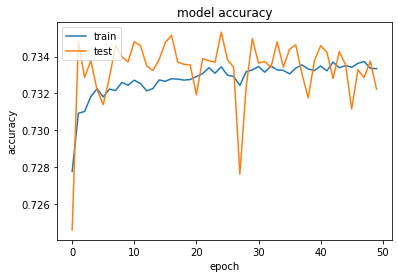

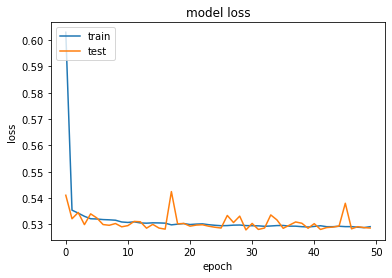

1458/1458 [==============================] - 1s 509us/step - loss: 0.5286 - accuracy: 0.7322
Test accuracy: 0.7322297692298889


In [19]:

predictions = model.predict(X_test)
y_pred = (predictions>0.5)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
display(conf_matrix)



# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)